# Uber Trips Analysis

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import folium
from folium import plugins
import warnings
warnings.filterwarnings('ignore')

Loading data

In [36]:
rides = pd.read_csv("trips_data.csv")

## Data Cleaning

Data Description

In [37]:
rides.head()

,City,Product Type,Trip or Order Status,Request Time,Begin Trip Time,Begin Trip Lat,Begin Trip Lng,Dropoff Time,Dropoff Lat,Dropoff Lng,Distance (miles),Fare Amount,Fare Currency
0,458,Black,COMPLETED,2021-01-13 22:06:46 +0000 UTC,2021-01-13 22:11:10 +0000 UTC,-23.599752,-46.715954,2021-01-13 22:29:13 +0000 UTC,-23.559359,-46.666542,4.84,29.63,BRL
1,458,VIP,COMPLETED,2021-01-13 20:21:05 +0000 UTC,2021-01-13 20:27:29 +0000 UTC,-23.559298,-46.666454,2021-01-13 20:54:50 +0000 UTC,-23.599585,-46.715717,5.31,20.86,BRL
2,458,VIP,COMPLETED,2021-01-03 00:23:22 +0000 UTC,2021-01-03 00:33:00 +0000 UTC,-23.626593,-46.659410,2021-01-03 00:50:56 +0000 UTC,-23.559273,-46.666595,5.90,34.23,BRL
3,458,VIP,COMPLETED,2020-12-11 23:16:33 +0000 UTC,2020-12-11 23:27:32 +0000 UTC,-23.559410,-46.666435,2020-12-12 00:32:47 +0000 UTC,-23.425755,-46.481190,19.74,58.77,BRL
4,458,VIP,COMPLETED,2020-12-11 00:35:46 +0000 UTC,2020-12-11 00:46:46 +0000 UTC,-23.584846,-46.663590,2020-12-11 00:57:57 +0000 UTC,-23.559261,-46.666510,2.54,12.63,BRL


In [38]:
rides.columns

Index(['City', 'Product Type', 'Trip or Order Status', 'Request Time',
       'Begin Trip Time', 'Begin Trip Lat', 'Begin Trip Lng', 'Dropoff Time',
       'Dropoff Lat', 'Dropoff Lng', 'Distance (miles)', 'Fare Amount',
       'Fare Currency'],
      dtype='object')

Clean up column names that contain whitespace

In [67]:
len(rides.columns)

21

In [39]:
rides.columns = rides.columns.str.replace(' ', '_')

In [40]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554 entries, 0 to 553
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   City                  554 non-null    int64  
 1   Product_Type          551 non-null    object 
 2   Trip_or_Order_Status  554 non-null    object 
 3   Request_Time          554 non-null    object 
 4   Begin_Trip_Time       554 non-null    object 
 5   Begin_Trip_Lat        525 non-null    float64
 6   Begin_Trip_Lng        525 non-null    float64
 7   Dropoff_Time          554 non-null    object 
 8   Dropoff_Lat           525 non-null    float64
 9   Dropoff_Lng           525 non-null    float64
 10  Distance_(miles)      554 non-null    float64
 11  Fare_Amount           554 non-null    float64
 12  Fare_Currency         551 non-null    object 
dtypes: float64(6), int64(1), object(6)
memory usage: 56.4+ KB


In [41]:
rides.isnull().sum()

City                     0
Product_Type             3
Trip_or_Order_Status     0
Request_Time             0
Begin_Trip_Time          0
Begin_Trip_Lat          29
Begin_Trip_Lng          29
Dropoff_Time             0
Dropoff_Lat             29
Dropoff_Lng             29
Distance_(miles)         0
Fare_Amount              0
Fare_Currency            3
dtype: int64

In [42]:
rides.dropna(inplace=True)

In [43]:
# Checking categories in Product_Type column
print(rides.Product_Type.value_counts())

Product_Type
UberX                   166
uberX                   140
uberX VIP                81
VIP                      69
POOL                     26
UberEATS Marketplace     10
POOL: MATCHED             8
Pool                      6
uberPOOL: MATCHED         5
uberPOOL                  5
Pool: MATCHED             4
Black                     3
UberBLACK                 1
uberx                     1
Name: count, dtype: int64


In Product_Type column,different values referring to the same category. So, reclassifying it.

In [44]:
# Categories reclassification
product_mapping = {'UberX':'UberX','uberX':'UberX','uberX VIP':'UberX','VIP':'UberX','POOL':'Pool','POOL: MATCHED':'Pool','UberBLACK': 'Black',
                   'uberx':'UberX','uberPOOL':'Pool','uberPOOL: MATCHED':'Pool','Pool: MATCHED':'Pool'}

# New categories replacement
rides['Product_Type'].replace(product_mapping, inplace=True)

# Checking new categories in product_type column
print(rides.Product_Type.value_counts())

Product_Type
UberX                   457
Pool                     54
UberEATS Marketplace     10
Black                     4
Name: count, dtype: int64


In [45]:
##checking different product types
rides["Product_Type"].unique()

array(['Black', 'UberX', 'UberEATS Marketplace', 'Pool'], dtype=object)

Removed the UberEATS records as it is not required for analysis.

In [46]:
rides = rides[rides.Product_Type!='UberEATS Marketplace']

 Request_Time, Begin_Trip_Time, Dropoff_Time from string to datetime

In [47]:
rides['Request_Time'] = rides['Request_Time'].apply(lambda x: x.replace(' +0000 UTC', ''))
rides['Request_Time'] = pd.to_datetime(rides['Request_Time'])

In [48]:
rides['Begin_Trip_Time'] = rides['Begin_Trip_Time'].apply(lambda x: x.replace(' +0000 UTC', ''))
rides['Begin_Trip_Time'] = pd.to_datetime(rides['Begin_Trip_Time'])

In [49]:
rides['Dropoff_Time'] = rides['Dropoff_Time'].apply(lambda x: x.replace(' +0000 UTC', ''))
rides['Dropoff_Time'] = pd.to_datetime(rides['Dropoff_Time'])

Request_Time is splitted with more suitable columns

In [50]:
rides['year'] = rides.Request_Time.map(lambda x: datetime.strftime(x,"%Y"))
rides['month'] = rides.Request_Time.map(lambda x: datetime.strftime(x,"%b"))
rides['weekday'] = rides.Request_Time.map(lambda x: datetime.strftime(x,"%a"))
rides['time'] = rides.Request_Time.map(lambda x: datetime.strftime(x,"%H:%M"))

Distance_km, Amount_km to understand how much it costs per kilometer.

In [51]:
rides['Distance_km'] = round(rides["Distance_(miles)"]*1.60934,2)
rides['Amount_km'] = round(rides["Fare_Amount"]/rides['Distance_km'],2)

Request_Lead_Time to understand delta time between and will now allow for how much time (in minutes) customers usually wait for Uber cars to reach their destination. Here, it is calculated on the basis of minutes.

In [52]:
rides['Request_Lead_Time'] = rides['Begin_Trip_Time'] - rides['Request_Time']
rides['Request_Lead_Time'] = rides['Request_Lead_Time'].apply(lambda x: round(x.total_seconds()/60,1))

Trip_Duration to understand the delta time between and will now allow for how much time (in minutes) is spent on each trip.

In [53]:
rides['Trip_Duration'] = rides['Dropoff_Time'] - rides['Begin_Trip_Time']
rides['Trip_Duration'] = rides['Trip_Duration'].apply(lambda x: round(x.total_seconds()/60,1))

Driver_Cancelled, Driver_Cancelled and Unfulfilled records will not be useful in the analysis. Hence, changing it as nan.

In [54]:
rides['Trip_or_Order_Status'].unique()

array(['COMPLETED', 'CANCELED', 'DRIVER_CANCELED'], dtype=object)

In [55]:
rides.loc[(rides['Trip_or_Order_Status'] == 'CANCELED') | (rides['Trip_or_Order_Status'] == 'DRIVER_CANCELED') | (rides['Trip_or_Order_Status'] == 'UNFULFILLED'),'Request_Lead_Time']=np.nan
rides.loc[(rides['Trip_or_Order_Status'] == 'CANCELED') | (rides['Trip_or_Order_Status'] == 'DRIVER_CANCELED') | (rides['Trip_or_Order_Status'] == 'UNFULFILLED'),'Amount_km']=np.nan
rides.loc[(rides['Trip_or_Order_Status'] == 'CANCELED') | (rides['Trip_or_Order_Status'] == 'DRIVER_CANCELED') | (rides['Trip_or_Order_Status'] == 'UNFULFILLED'),['Begin_Trip_Time','Dropoff_Time']]= np.nan

## Data Analysis

Excluding all trips with CANCELED,DRIVER_CANCELED and UNFULFILLED as they should not be considered in some queries.

In [56]:
completed_rides = rides[(rides['Trip_or_Order_Status']!='CANCELED')&(rides['Trip_or_Order_Status']!='DRIVER_CANCELED')&(rides['Trip_or_Order_Status']!='UNFULFILLED')]

Total trips:  444
year
2016     17
2017    120
2018    146
2019    106
2020     52
2021      3
Name: count, dtype: int64


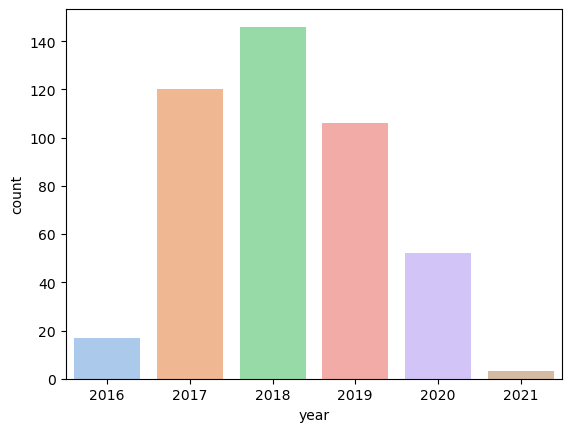

In [57]:
print('Total trips: ', completed_rides["Trip_or_Order_Status"].count())
print(completed_rides["year"].value_counts().sort_index(ascending=True))
sns.countplot(data=completed_rides, x='year',order=['2016','2017','2018','2019','2020','2021'], palette='pastel');

444 trips completed from Apr’16 to Jan’21. With exception of 2016 and 2021 (not full years), it can be clearly seen that from 2017 to 2019 mid-year passengers are 124, and that there is a significant decrease from 2019 to 2020 (-51%). This is easily explained by the outbreak of COVID.

Total trips:  515
Trip_or_Order_Status
COMPLETED          86.2
CANCELED           11.8
DRIVER_CANCELED     1.9
Name: count, dtype: float64


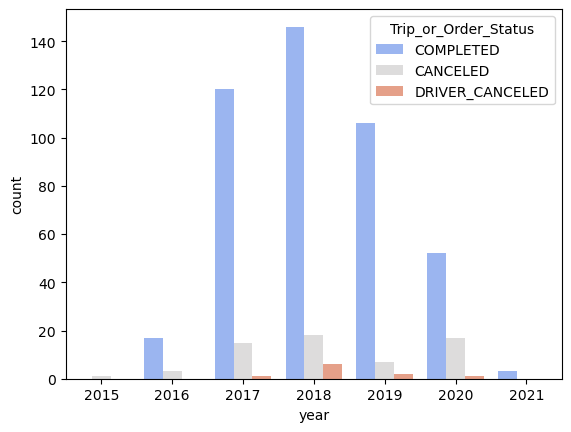

In [58]:
print('Total trips: ', rides["Trip_or_Order_Status"].count())
print(round(rides["Trip_or_Order_Status"].value_counts()/rides["Trip_or_Order_Status"].size*100,1))
sns.countplot(data=rides, x='year', order=['2015','2016','2017','2018','2019','2020','2021'], hue='Trip_or_Order_Status', palette='coolwarm');

With exception of 2015 and 2021 (due to low travel volume), 2020 has the highest cancellation record.

              count     %
Product_Type             
UberX           401  90.3
Pool             39   8.8
Black             4   0.9


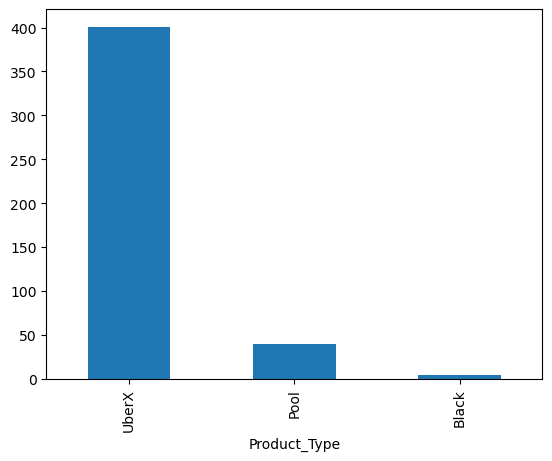

In [59]:
# Creating a serie with product types count
pt_rides = pd.Series(completed_rides["Product_Type"].value_counts().sort_index(ascending=False))
# Transforming serie in dataframe
df = pd.DataFrame(pt_rides)
# Including new column with trips portion
df['%'] = (completed_rides["Product_Type"].value_counts().sort_index(ascending=False)/completed_rides["Product_Type"].size*100).round(1)
#Renaming columns labels
df.rename(columns={'Product_Type':'Total Rides'}, inplace=True)
print(df)
# Plotting product types count
completed_rides['Product_Type'].value_counts().plot(kind='bar');

UberX is the preferred product type with a frequency of 90.3%, as it is more affordable than others. 



In [60]:
print('Avg. fare:', round(completed_rides["Fare_Amount"].mean(),1),'BRL')
print('Avg. distance:',round(completed_rides["Distance_km"].mean(),1),'km')
print('Avg. fare/km:',round(completed_rides["Fare_Amount"].sum()/completed_rides["Distance_km"].sum(),1),'BRL/km')
print('Avg. time spent on trips:',round(completed_rides["Trip_Duration"].mean(),1),'minutes')
print('')
print('Total fare amount:', round(completed_rides["Fare_Amount"].sum(),1),'BRL')
print('Total distance:',round(completed_rides["Distance_km"].sum(),1),'km')
print('Total time spent on trips:',round(completed_rides["Trip_Duration"].sum()/60,1),'hours')

Avg. fare: 19.2 BRL
Avg. distance: 8.1 km
Avg. fare/km: 2.4 BRL/km
Avg. time spent on trips: 21.4 minutes

Total fare amount: 8532.8 BRL
Total distance: 3575.0 km
Total time spent on trips: 158.4 hours


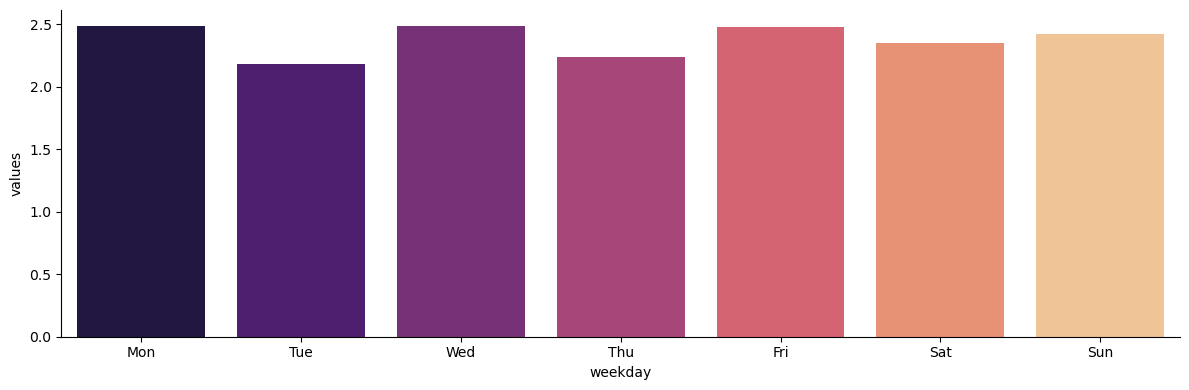

In [61]:
#creating an auxiliar data frame to be displayed in category plot
aux_serie = round((completed_rides.groupby('weekday')['Fare_Amount'].sum()/completed_rides.groupby('weekday')['Distance_km'].sum()),2)                                                                                                                              
amount_km_df = pd.DataFrame(aux_serie)
amount_km_df = amount_km_df.reset_index()
amount_km_df.rename(columns={'weekday':'weekday',0:'values'},inplace=True)
sns.catplot(x='weekday', y='values', data=amount_km_df, kind='bar', height=4, aspect=3, order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],palette='magma');

As observed, Monday, Wednesday, Friday, and Sunday are the most expensive days of the week. 

In [62]:
rides_distance_max = completed_rides[completed_rides["Distance_km"]==completed_rides["Distance_km"].max()]
rides_distance_min = completed_rides[completed_rides["Distance_km"]==completed_rides["Distance_km"].min()]
rides_distance = pd.concat([rides_distance_max,rides_distance_min])
rides_distance

,City,Product_Type,Trip_or_Order_Status,Request_Time,Begin_Trip_Time,Begin_Trip_Lat,Begin_Trip_Lng,Dropoff_Time,Dropoff_Lat,Dropoff_Lng,...,Fare_Amount,Fare_Currency,year,month,weekday,time,Distance_km,Amount_km,Request_Lead_Time,Trip_Duration
3,458,UberX,COMPLETED,2020-12-11 23:16:33,2020-12-11 23:27:32,-23.559410,-46.666435,2020-12-12 00:32:47,-23.425755,-46.481190,...,58.77,BRL,2020,Dec,Fri,23:16,31.77,1.85,11.0,65.2
305,458,UberX,COMPLETED,2018-04-15 23:18:40,2018-04-15 23:27:42,-23.502636,-46.624952,2018-04-15 23:34:17,-23.503310,-46.636808,...,11.27,BRL,2018,Apr,Sun,23:18,0.24,46.96,9.0,6.6


The table below shows the longest ride (31.77 km) and the shortest ride (0.24 km).

In [63]:
rides_amount_km_max = completed_rides[completed_rides["Amount_km"]==completed_rides["Amount_km"].max()]
rides_amount_km_min = completed_rides[completed_rides["Amount_km"]==completed_rides["Amount_km"].min()]
rides_amount_km = pd.concat([rides_amount_km_max,rides_amount_km_min])
rides_amount_km

,City,Product_Type,Trip_or_Order_Status,Request_Time,Begin_Trip_Time,Begin_Trip_Lat,Begin_Trip_Lng,Dropoff_Time,Dropoff_Lat,Dropoff_Lng,...,Fare_Amount,Fare_Currency,year,month,weekday,time,Distance_km,Amount_km,Request_Lead_Time,Trip_Duration
305,458,UberX,COMPLETED,2018-04-15 23:18:40,2018-04-15 23:27:42,-23.502636,-46.624952,2018-04-15 23:34:17,-23.503310,-46.636808,...,11.27,BRL,2018,Apr,Sun,23:18,0.24,46.96,9.0,6.6
87,458,UberX,COMPLETED,2019-11-30 03:34:56,2019-11-30 03:40:37,-23.591813,-46.690720,2019-11-30 03:53:24,-23.559366,-46.666489,...,0.00,BRL,2019,Nov,Sat,03:34,5.70,0.00,5.7,12.8


The full paid mileage price: expensive (46.96 BRL / km) and cheap (0 BRL / km).

In [64]:
print(round(completed_rides["Request_Lead_Time"].mean(),1),'minutes')

4.9 minutes


It takes about five minutes to start the journey, after which it has been requested.

## Recommendations

- Since not many people travel through Pool, Black they should increase the UberX rides to gain profit. As it is more affordable than others.
- Uber can lead offers on rides during festival seasons to attract customers which might take long-distance rides.
- Short-distance Uber rides are quite cheap, compared to long-distance. Uber can fix some amount per kilometer can set minimum limit for traveling in Uber.




In [65]:
rides

,City,Product_Type,Trip_or_Order_Status,Request_Time,Begin_Trip_Time,Begin_Trip_Lat,Begin_Trip_Lng,Dropoff_Time,Dropoff_Lat,Dropoff_Lng,...,Fare_Amount,Fare_Currency,year,month,weekday,time,Distance_km,Amount_km,Request_Lead_Time,Trip_Duration
0,458,Black,COMPLETED,2021-01-13 22:06:46,2021-01-13 22:11:10,-23.599752,-46.715954,2021-01-13 22:29:13,-23.559359,-46.666542,...,29.63,BRL,2021,Jan,Wed,22:06,7.79,3.80,4.4,18.1
1,458,UberX,COMPLETED,2021-01-13 20:21:05,2021-01-13 20:27:29,-23.559298,-46.666454,2021-01-13 20:54:50,-23.599585,-46.715717,...,20.86,BRL,2021,Jan,Wed,20:21,8.55,2.44,6.4,27.4
2,458,UberX,COMPLETED,2021-01-03 00:23:22,2021-01-03 00:33:00,-23.626593,-46.659410,2021-01-03 00:50:56,-23.559273,-46.666595,...,34.23,BRL,2021,Jan,Sun,00:23,9.50,3.60,9.6,17.9
3,458,UberX,COMPLETED,2020-12-11 23:16:33,2020-12-11 23:27:32,-23.559410,-46.666435,2020-12-12 00:32:47,-23.425755,-46.481190,...,58.77,BRL,2020,Dec,Fri,23:16,31.77,1.85,11.0,65.2
4,458,UberX,COMPLETED,2020-12-11 00:35:46,2020-12-11 00:46:46,-23.584846,-46.663590,2020-12-11 00:57:57,-23.559261,-46.666510,...,12.63,BRL,2020,Dec,Fri,00:35,4.09,3.09,11.0,11.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,458,Pool,COMPLETED,2016-06-22 11:07:02,2016-06-22 11:14:17,-23.616073,-46.665949,2016-06-22 11:24:28,-23.602760,-46.644897,...,7.84,BRL,2016,Jun,Wed,11:07,3.54,2.21,7.2,10.2
550,458,UberX,COMPLETED,2016-04-07 00:30:46,2016-04-07 00:35:23,-23.569478,-46.672408,2016-04-07 00:50:14,-23.602737,-46.645352,...,15.06,BRL,2016,Apr,Thu,00:30,6.57,2.29,4.6,14.8
551,458,UberX,COMPLETED,2016-04-06 21:16:52,2016-04-06 21:20:44,-23.602608,-46.645084,2016-04-06 21:41:30,-23.569549,-46.672412,...,15.16,BRL,2016,Apr,Wed,21:16,5.55,2.73,3.9,20.8
552,458,UberX,CANCELED,2016-04-06 21:12:03,NaT,-23.601718,-46.646871,NaT,-23.600862,-46.644494,...,0.00,BRL,2016,Apr,Wed,21:12,0.00,NaN,NaN,0.0
